In [1]:
%pip install geopandas


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datetime import datetime
import geopandas as gpd
import json
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from shapely.geometry import Point

from geopandas import GeoDataFrame
import plotly.express as px

#Get Greater London Background for map plot
from shapely.geometry import Point


%matplotlib inline

In [ ]:
def download(bucket_name, key, dst_root='/tmp'):
    """ Download csv directory from S3"""
    resource = boto3.resource('s3')
    resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)

    bucket = resource.Bucket(bucket_name)
    for object in bucket.objects.filter(Prefix = key):
        dst = dst_root+'/'+object.key
        if not os.path.exists(os.path.dirname(dst)):
            os.makedirs(os.path.dirname(dst))
        resource.Bucket(bucket_name).download_file(object.key, dst)
        


In [ ]:
def file_setup(bucket_name,key):
    tmp_dir = '/tmp'
    tmp_file = tmp_dir + '/'+key

    if not os.path.exists(os.path.dirname(tmp_file)):
    os.makedirs(os.path.dirname(tmp_file))

    download(bucket_name, key)



#West side london
bucket_name = 'dataforgood-fb-data/demographic_csvs/population/'
key = 'population_lat_50_lon_-10.csv'
file_setup(bucket_name,key)

#East side london
bucket_name = 'dataforgood-fb-data/demographic_csvs/population/'
key = 'population_lat_50_lon_0.csv'
file_setup(bucket_name,key)


In [ ]:
bucket='dataforgood-fb-data/demographic_csvs/population/'
file_key = 'population_lat_50_lon_-10.csv'
s3uri = 's3://{}/{}'.format(bucket, file_key)


In [ ]:
bucket='dataforgood-fb-data/demographic_csvs/population/'
file_key = 'population_lat_50_lon_0.csv'
s3uri = 's3://{}/{}'.format(bucket, file_key)



In [3]:
"""
    - Getting datasets (West and East side of London) from original s3 bucket and saving locally
    - Then filtering the data to Greater London
"""

#Original s3 buckets, copy files to local folder
##United Kingdom
#!aws --no-sign-request s3 cp s3://dataforgood-fb-data/demographic_csvs/population/population_lat_50_lon_-10.csv ./Data4_ASDI3_CIESIN_Meta/population_lat_50_lon_-10.csv
#!aws --no-sign-request s3 cp s3://dataforgood-fb-data/demographic_csvs/population/population_lat_50_lon_0.csv ./Data4_ASDI3_CIESIN_Meta/population_lat_50_lon_0.csv



#df_pop = pd.read_csv('Data4_ASDI3_CIESIN_Meta/population_lat_50_lon_-10.csv')

# Filter the population data to Greater London areas 
# -0.746574,51.265100,0.561486,51.693166  (lng/lat)
# 51.265100,-0.746574,51.693166,0.561486 (lat/lng)

# df_pop_scaled = df_pop[(51.265100 < df_pop['latitude']) & (df_pop['latitude'] < 51.693166) & (-0.746574< df_pop['longitude']) & (df_pop['longitude'] < 0.561486)]
# df_pop_scaled.to_csv('longitudeNeg10.csv')

#East London
# df_pop = pd.read_csv('Data4_ASDI3_CIESIN_Meta/population_lat_50_lon_0.csv')

# # Filter the population data to Greater London areas
# # -0.746574,51.265100,0.561486,51.693166  (lng/lat)
# # 51.265100,-0.746574,51.693166,0.561486 (lat/lng)

# df_pop_scaled = df_pop[(51.265100 < df_pop['latitude']) & (df_pop['latitude'] < 51.693166) & (-0.746574< df_pop['longitude']) & (df_pop['longitude'] < 0.561486)]
# df_pop_scaled.to_csv('longitude0.csv')

In [ ]:
#West-side London

#Get preprocessed data           
df_pop_scaled = pd.read_csv('tmp/population_lat_50_lon_-10.csv')
# Convert df into a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_pop_scaled['longitude'], df_pop_scaled['latitude'])]
pop_scaled_gdf = gpd.GeoDataFrame(df_pop_scaled, geometry=geometry)
#Set crs
pop_scaled_gdf.set_crs(epsg='4269', inplace=True)
pop_scaled_NegTen = pop_scaled_gdf



#East-side London

#Get preprocessed data
df_pop_scaled = pd.read_csv('tmp/population_lat_50_lon_0.csv')
# Convert df into
geometry = [Point(xy) for xy in zip(df_pop_scaled['longitude'], df_pop_scaled['latitude'])]
pop_scaled_gdf = gpd.GeoDataFrame(df_pop_scaled, geometry=geometry)
#set crs
pop_scaled_gdf.set_crs(epsg='4269', inplace=True)
pop_scaled_Zero = pop_scaled_gdf


#Map of Greater London
greater_london_df = gpd.read_file('greater_london_map/MSOA_2004_London_High_Resolution.shp')
greater_london_df_proj = greater_london_df.to_crs({'init': 'epsg:4269'})

In [13]:
pop_scaled_NegTen.head()

Unnamed: 0   latitude  longitude  population                   geometry
0      126943  51.620417  -0.288472   46.080284  POINT (-0.28847 51.62042)
1      126944  51.620417  -0.289306   46.080284  POINT (-0.28931 51.62042)
2      126945  51.620417  -0.289028   46.080284  POINT (-0.28903 51.62042)
3      126946  51.620139  -0.288194   46.080284  POINT (-0.28819 51.62014)
4      126947  51.620139  -0.288750   46.080284  POINT (-0.28875 51.62014)

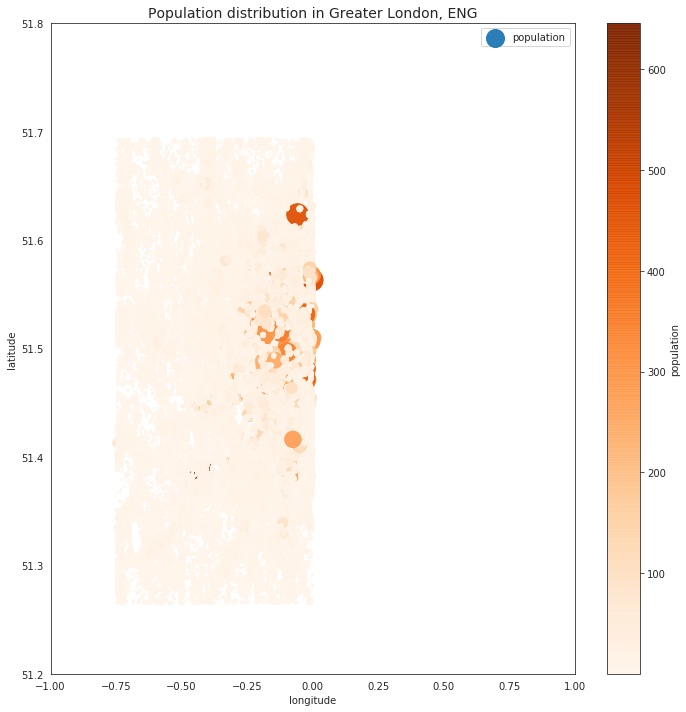

In [4]:
#Map West-side of London

with sns.axes_style('white'): 
    fig, ax = plt.subplots(figsize=(10,10))
    
    ##BACKGROUND IMAGE
    #clark_county_df.plot(ax=ax,color='#A9E4FC', zorder=1)
    #lv_area_df_select_proj.plot(ax=ax, color='#404040', zorder=3, alpha=0.22)

    pop_scaled_gdf.plot(ax=ax, kind="scatter", x="longitude", y="latitude",
        s=pop_scaled_gdf['population'], label="population",
        c="population", cmap=plt.get_cmap("Oranges"),
        colorbar=True, alpha=0.95, zorder=2
    )

    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(51.20, 51.80)

    plt.title("Population distribution in Greater London, ENG", fontsize=14)
    plt.tight_layout()
    plt.show()

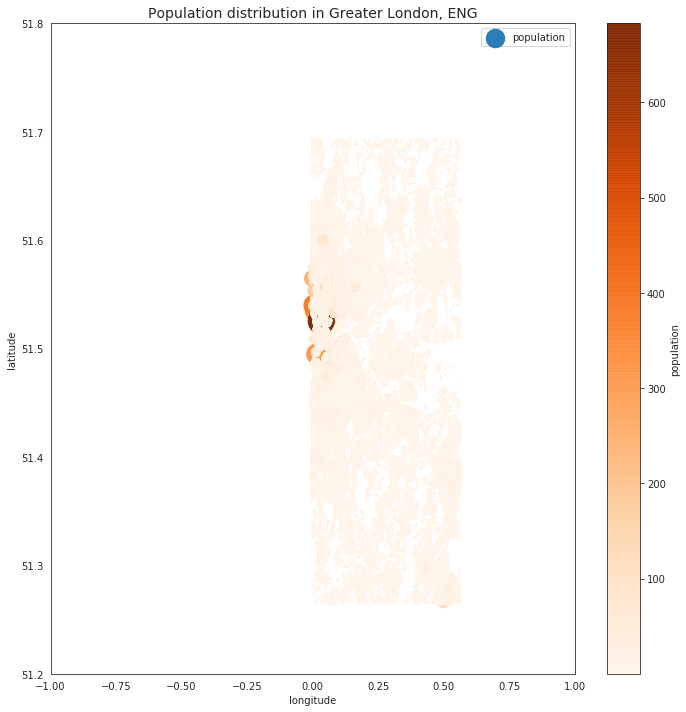

In [5]:
#Map East-side of london
with sns.axes_style('white'): 
    fig, ax = plt.subplots(figsize=(10,10))
    
    ##Backgrounds
    #clark_county_df.plot(ax=ax,color='#A9E4FC', zorder=1)
    #lv_area_df_select_proj.plot(ax=ax, color='#404040', zorder=3, alpha=0.22)

    pop_scaled_gdf.plot(ax=ax, kind="scatter", x="longitude", y="latitude",
        s=pop_scaled_gdf['population'], label="population",
        c="population", cmap=plt.get_cmap("Oranges"),
        colorbar=True, alpha=0.95, zorder=2
    )

    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(51.20, 51.80)

    plt.title("Population distribution in Greater London, ENG", fontsize=14)
    plt.tight_layout()
    plt.show()

In [11]:
"""
    Use High resolution shapefile of greater london to plot a map
    shapefile is from https://data.london.gov.uk/dataset?tag=shapefile&tag=shape&tag=shapefiles&geo=Output%20Area
"""
# greater_london_df = gpd.read_file('greater_london_map/MSOA_2004_London_High_Resolution.shp')

# print(greater_london_df.shape)
# print(greater_london_df.head(10))
# greater_london_df_proj = greater_london_df.to_crs({'init': 'epsg:4269'})

(983, 10)
   MSOA_CODE                 MSOA_NAME LA_CODE               LA_NAME  GEOEAST  \
0  E02000001        City of London 001    00AA        City of London   532464   
1  E02000002  Barking and Dagenham 001    00AB  Barking and Dagenham   548313   
2  E02000003  Barking and Dagenham 002    00AB  Barking and Dagenham   548456   
3  E02000004  Barking and Dagenham 003    00AB  Barking and Dagenham   551010   
4  E02000005  Barking and Dagenham 004    00AB  Barking and Dagenham   548666   
5  E02000006  Barking and Dagenham 005    00AB  Barking and Dagenham   547547   
6  E02000007  Barking and Dagenham 006    00AB  Barking and Dagenham   549651   
7  E02000008  Barking and Dagenham 007    00AB  Barking and Dagenham   548141   
8  E02000009  Barking and Dagenham 008    00AB  Barking and Dagenham   546968   
9  E02000010  Barking and Dagenham 009    00AB  Barking and Dagenham   549066   

   GEONORTH  POPEAST  POPNORTH  AREA_KM2  \
0    181220   532458    181630  3.151470   
1    18987

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


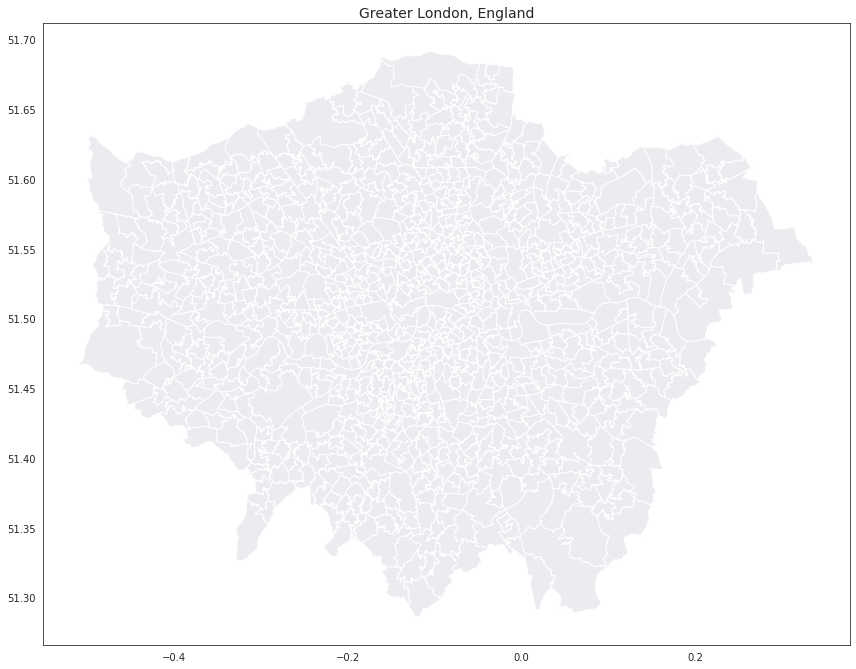

In [10]:
greater_london_df_proj.to_crs(epsg='4269', inplace=True)

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(12,12))
    greater_london_df_proj.plot(ax=ax,color='#EBECF0')
    plt.title("Greater London, England", fontsize=14)
    plt.tight_layout()
    plt.show()

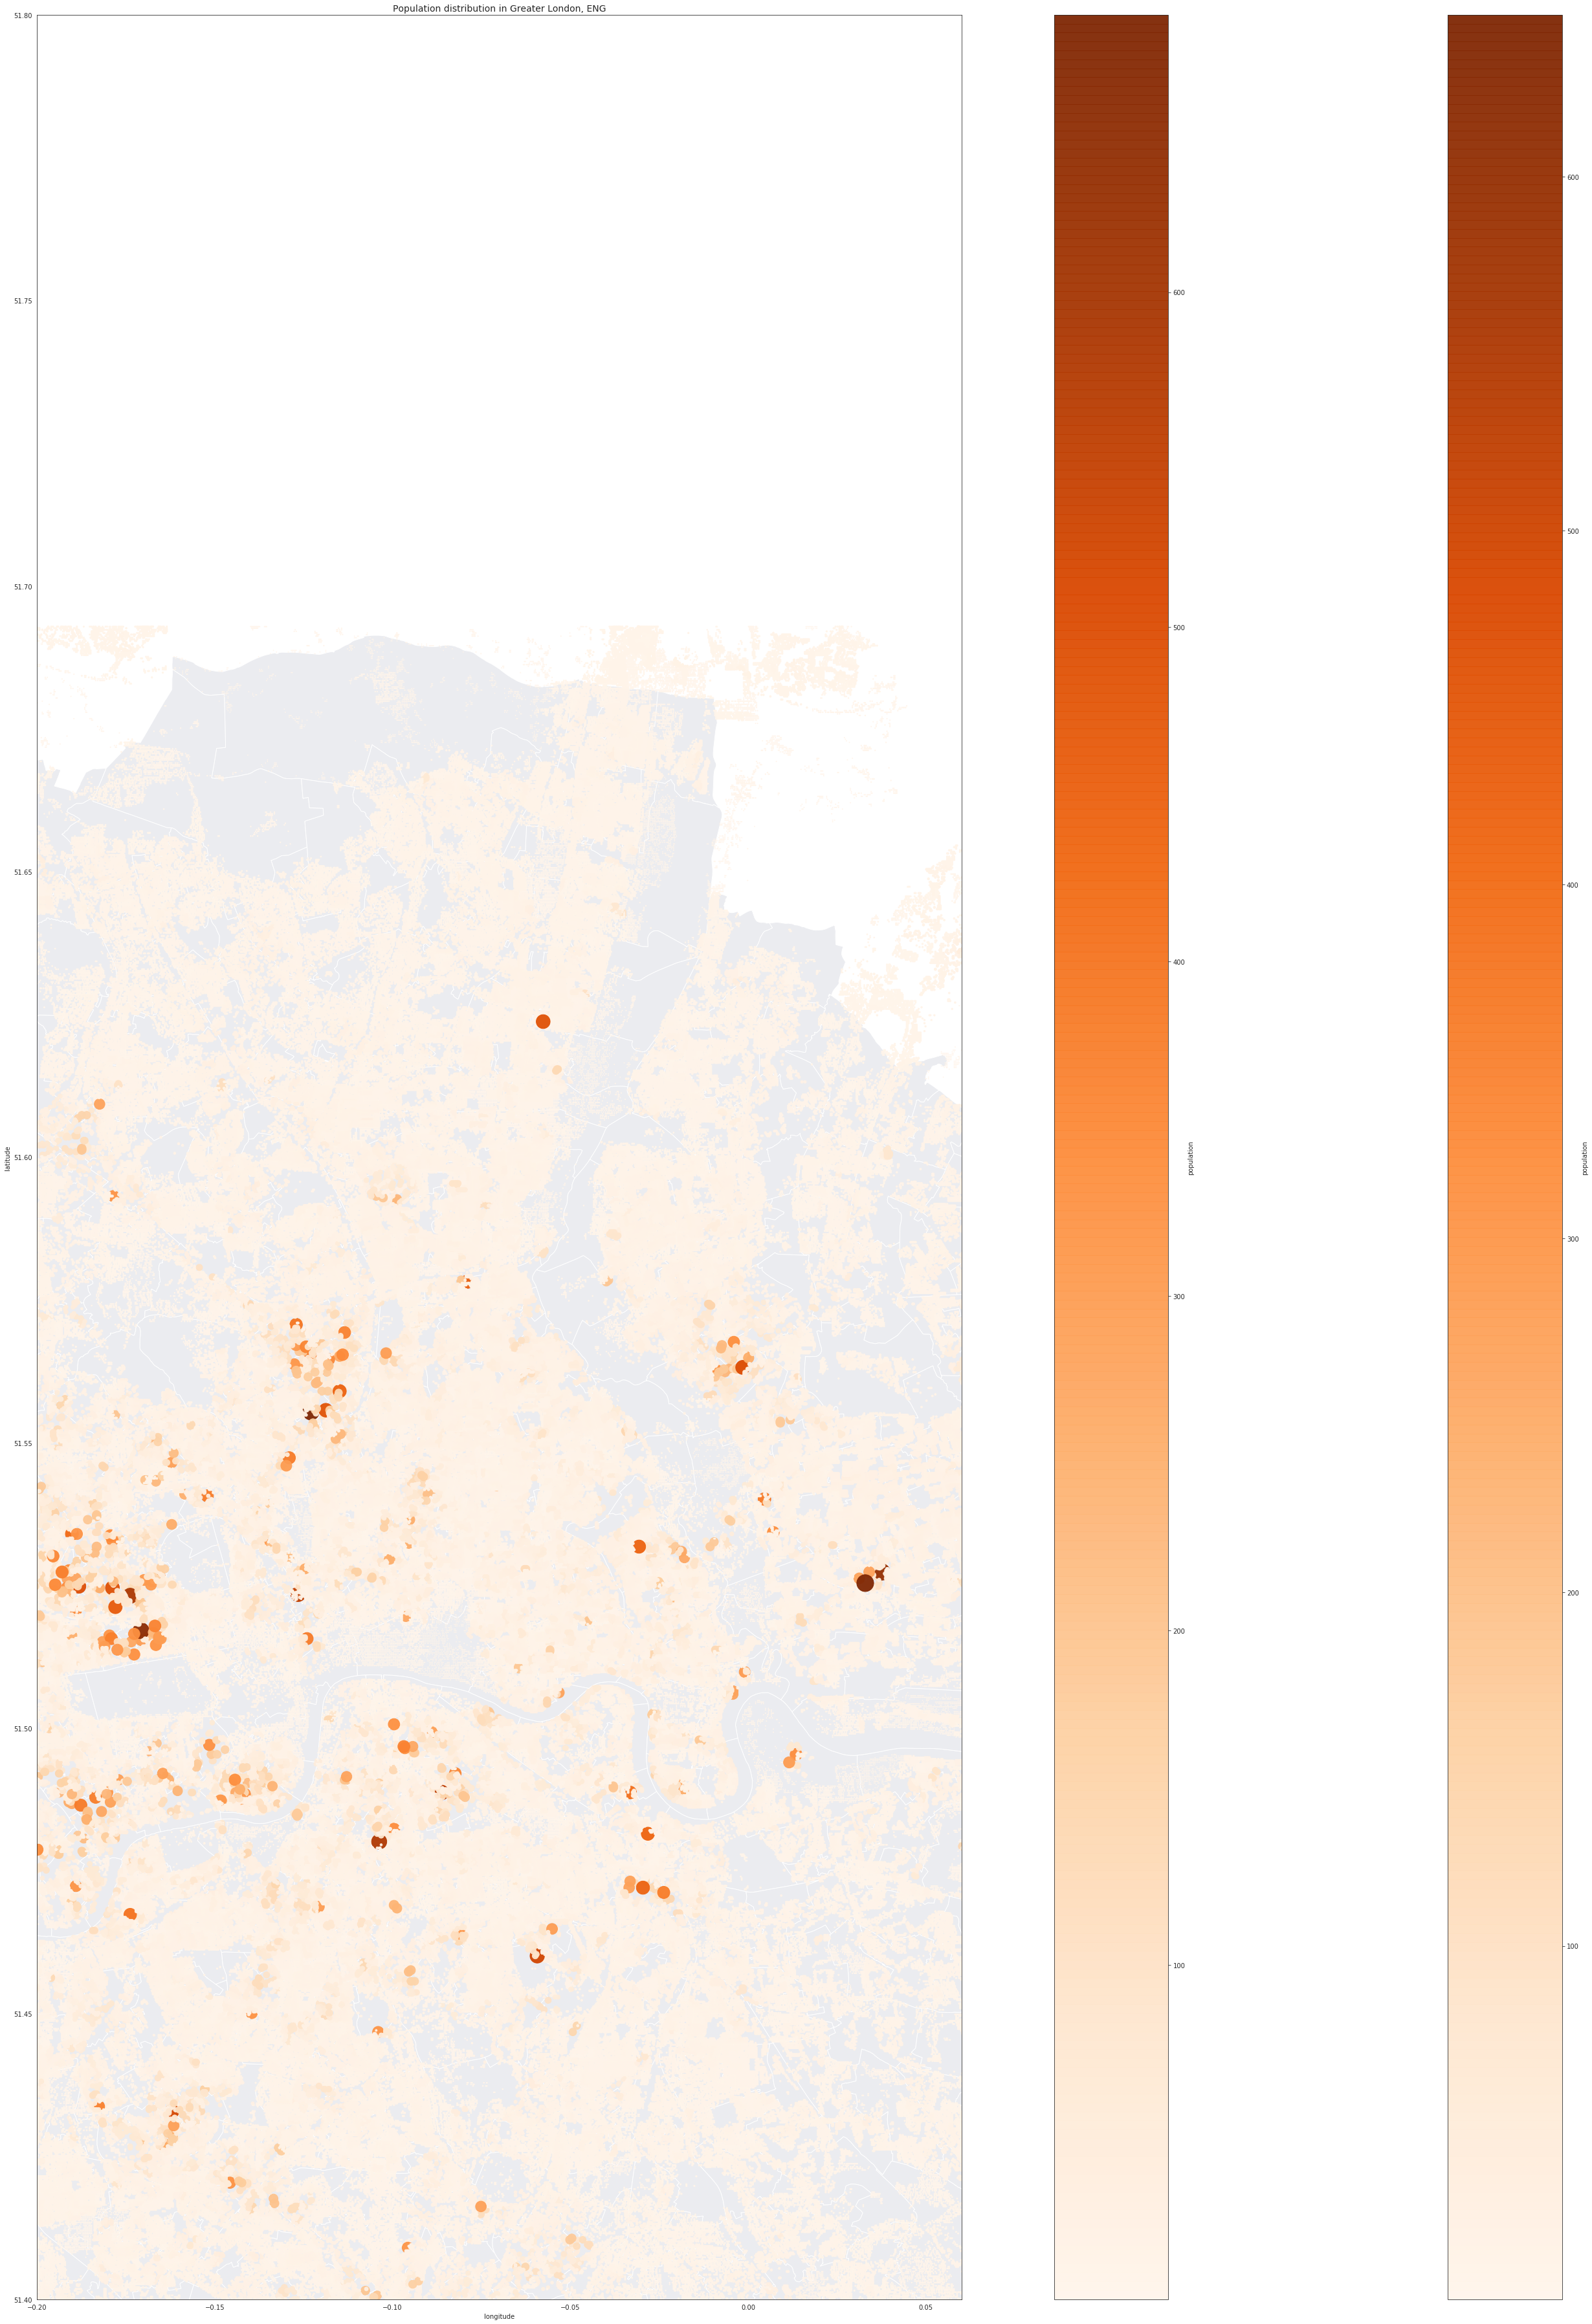

In [12]:
#Set correct epsg values

pop_scaled_NegTen.set_crs(epsg='4269', inplace=True)
pop_scaled_Zero.set_crs(epsg='4269', inplace=True)

#greater_london_df.to_crs(greater_london_df.crs)


#pop_scaled_gdf_proj = pop_scaled_gdf.to_crs(clark_county_df.crs)


#greater_london_df_proj = greater_london_df.to_crs({'init': 'epsg:3857'})
#pop_scaled_NegTen_proj = pop_scaled_NegTen.to_crs(greater_london_df.crs)
#pop_scaled_Zero_proj = pop_scaled_Zero.to_crs(greater_london_df.crs)

with sns.axes_style('white'): 
    fig, ax = plt.subplots(figsize=(50,50))

    ##Backgrounds
    #clark_county_df.plot(ax=ax,color='#A9E4FC', zorder=1)
    #lv_area_df_select_proj.plot(ax=ax, color='#404040', zorder=3, alpha=0.22)
    greater_london_df_proj.plot(ax=ax,color='#EBECF0', zorder=1)
    
    
    pop_scaled_NegTen.plot(ax=ax, kind="scatter", x="longitude", y="latitude",
        s=pop_scaled_NegTen['population'],
        c="population", cmap=plt.get_cmap("Oranges"),
        colorbar=True, alpha=0.95, zorder=2
    )
    
    pop_scaled_Zero.plot(ax=ax, kind="scatter", x="longitude", y="latitude",
        s=pop_scaled_Zero['population'],
        c="population", cmap=plt.get_cmap("Oranges"),
        alpha=0.95, zorder=2
    )
    
    # -0.746574,51.265100,0.561486,51.693166  (lng/lat)
    # 51.265100,-0.746574,51.693166,0.561486 (lat/lng)

    ax.set_xlim(-0.2, 0.06)
    ax.set_ylim(51.40, 51.80)

    plt.title("Population distribution in Greater London, ENG", fontsize=14)
    plt.tight_layout()
    
    #Save image first then .show() otherwise, it'll save as a blank image
    plt.savefig('high_res_gLondon(-0.26, 0.06)with_map.png')
    
    plt.show()